In [1]:
import os
import numpy as np
import scipy.stats
import joblib
import pandas as pd
import sklearn.neighbors
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import torch
import scvi.dataset
import scvi.models
import scvi.inference
import scvi.inference.annotation
import Cell_BLAST as cb

import exputils

random_state = np.random.RandomState(0)

cb.config.RANDOM_SEED = 0
cb.config.N_JOBS = 8
N_MODELS = 8
N_RANDOM_PAIRS = 10000

PATH = "./distance_comparison/pancreas/"

---

# Load data

In [2]:
# Reference
ref = cb.data.ExprDataSet.merge_datasets(dict(
    baron=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Baron_human/data.h5"),
    xin=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Xin_2016/data.h5"),
    lawlor=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Lawlor/data.h5")
), merge_uns_slots=["seurat_genes"]).normalize()
ref = ref[:, ref.uns["seurat_genes"]]
ref = exputils.clean_dataset(ref, "cell_ontology_class")
ref.to_anndata().write_h5ad(os.path.join(PATH, "ref.h5ad"))
ref_scvi = scvi.dataset.AnnDataset("ref.h5ad", save_path=PATH)
ref_scvi.batch_indices = cb.utils.encode_integer(ref.obs["dataset_name"])[0].reshape((-1, 1))
n_batch = np.unique(ref_scvi.batch_indices).size

[ Warning ] 20984 out of 41109 variables are not found, will be set to zero!
[ Warning ] 1258 out of 41109 variables are not found, will be set to zero!
[ Warning ] 21224 out of 41109 variables are not found, will be set to zero!
[  Info   ] Merging uns slots...
[  Info   ] Merging var data frame...
[  Info   ] Merging obs data frame...
[  Info   ] Merging expression matrix...
[  Info   ] Cleaning removed 0 cells.


... storing 'bmi' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'cell_type1' as categorical
... storing 'dataset_name' as categorical
... storing 'donor' as categorical
... storing 'ethnicity' as categorical
... storing 'gender' as categorical
... storing 'library' as categorical
... storing 'lifestage' as categorical
... storing 'organ' as categorical
... storing 'organism' as categorical
... storing 'platform' as categorical


File ./distance_comparison/pancreas/ref.h5ad already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [3]:
query = dict(
    # Positive
    segerstolpe=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Segerstolpe/data.h5"),
    muraro=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Muraro/data.h5"),
    enge=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Enge/data.h5"),
    # Negative
    young=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Young/data.h5"),
    wu_human=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Wu_human/data.h5"),
    zheng=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Zheng/data.h5"),
    philippeos=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Philippeos/data.h5")
)

min_size = max(min(val.shape[0] for val in query.values()), 2000)
query = cb.data.ExprDataSet.merge_datasets({
    key: val.normalize()[
        random_state.choice(val.shape[0], min(min_size, val.shape[0]), replace=False),
        ref.var_names
    ] for key, val in query.items()
})
query = exputils.clean_dataset(query, "cell_ontology_class")

query.to_anndata().write_h5ad(os.path.join(PATH, "query.h5ad"))
query_scvi = scvi.dataset.AnnDataset("query.h5ad", save_path=PATH)

[ Warning ] 1 out of 1751 variables are not found, will be set to zero!
[ Warning ] 16 out of 1751 variables are not found, will be set to zero!
[ Warning ] 40 out of 1751 variables are not found, will be set to zero!
[ Warning ] 4 out of 1751 variables are not found, will be set to zero!
[ Warning ] 246 out of 1751 variables are not found, will be set to zero!
[  Info   ] Merging uns slots...
[  Info   ] Merging var data frame...
[  Info   ] Merging obs data frame...
[  Info   ] Merging expression matrix...
[  Info   ] Cleaning removed 0 cells.


... storing 'ClusterID' as categorical
... storing 'age' as categorical
... storing 'batch' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'cell_type0' as categorical
... storing 'cell_type1' as categorical
... storing 'cell_type2' as categorical
... storing 'dataset_name' as categorical
... storing 'donor' as categorical
... storing 'gender' as categorical
... storing 'lifestage' as categorical
... storing 'organ' as categorical
... storing 'organism' as categorical
... storing 'platform' as categorical
... storing 'region' as categorical


File ./distance_comparison/pancreas/query.h5ad already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [4]:
ref_cl = np.array(ref.obs["cell_ontology_class"])
query_cl = np.array(query.obs["cell_ontology_class"])
cl_lut = {
    item: (
        np.where(query_cl != item)[0],
        np.where(query_cl == item)[0]
    ) for item in np.unique(ref_cl)
}
ref_idx, query_idx, correctness = [], [], []
for idx in range(N_RANDOM_PAIRS):
    lut_use = idx < N_RANDOM_PAIRS / 2
    while True:
        i = random_state.choice(ref.shape[0], 1)[0]
        cl = ref_cl[i]
        if cl_lut[cl][lut_use].size:
            ref_idx.append(i)
            query_idx.append(random_state.choice(cl_lut[cl][lut_use], 1)[0])
            correctness.append(lut_use)
            break
ref_idx, query_idx, correctness = np.array(ref_idx), np.array(query_idx), np.array(correctness)

---

# scVI

In [5]:
scvi_models = []
for seed in range(N_MODELS):
    print("==== model %d ====" % seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    vae = scvi.models.VAE(ref_scvi.nb_genes, n_latent=10, n_batch=n_batch)
    trainer = scvi.inference.annotation.UnsupervisedTrainer(
        vae, ref_scvi, use_cuda=True, metrics_to_monitor=["ll"], frequency=5,
        early_stopping_kwargs=dict(
            early_stopping_metric="ll", save_best_state_metric="ll",
            patience=20, threshold=0
        )
    )
    trainer.train(n_epochs=300)
    scvi_models.append(vae)

==== model 0 ====
training:  61%|██████▏   | 184/300 [02:11<01:22,  1.40it/s]
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
training:  62%|██████▏   | 185/300 [02:12<01:22,  1.40it/s]
==== model 1 ====
training:  68%|██████▊   | 204/300 [02:17<01:04,  1.48it/s]
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
training:  68%|██████▊   | 205/300 [02:18<01:04,  1.48it/s]
==== model 2 ====
training:  78%|███████▊  | 234/300 [03:01<00:51,  1.29it/s]
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
training:  78%|███████▊  | 235/300 [03:02<00:50,  1.29it/s]
==== model 3 ====
training:  66%|██████▋   | 1

In [6]:
def scvi_roc(model):
    _trainer = scvi.inference.annotation.UnsupervisedTrainer(model, ref_scvi)
    tmp = _trainer.get_all_latent_and_imputed_values()
    ref_zm, ref_zv = tmp["latent"], tmp["latent_var"]
    _trainer = scvi.inference.annotation.UnsupervisedTrainer(model, query_scvi)
    tmp = _trainer.get_all_latent_and_imputed_values()
    query_zm, query_zv = tmp["latent"], tmp["latent_var"]
    
    # Euclidean distance
    eud = np.sqrt(np.square(ref_zm[ref_idx] - query_zm[query_idx]).sum(axis=1))
    fpr, tpr, thresh = sklearn.metrics.roc_curve(correctness, -eud)
    eud_auc = sklearn.metrics.roc_auc_score(correctness, -eud)
    eud_fpr, eud_tpr = exputils.subsample_roc(fpr, tpr)
    
    # Posterior NPD (Normalized Projection Distance)
    ref_zm_noisy, query_zm_noisy = [], []
    random_state = np.random.RandomState(0)
    for i in tqdm.tqdm_notebook(range(ref_zm.shape[0]), leave=False):
        ref_zm_noisy.append(random_state.multivariate_normal(
            ref_zm[i], np.diag(ref_zv[i]), size=50
        ).astype(np.float32))
    for i in tqdm.tqdm_notebook(range(query_zm.shape[0]), leave=False):
        query_zm_noisy.append(random_state.multivariate_normal(
            query_zm[i], np.diag(query_zv[i]), size=50
        ).astype(np.float32))
    ref_zm_noisy, query_zm_noisy = \
        np.stack(ref_zm_noisy, axis=0), np.stack(query_zm_noisy, axis=0)
    pnpd = exputils.normalized_projection_distance(
        ref_zm[ref_idx], query_zm[query_idx],
        ref_zm_noisy[ref_idx], query_zm_noisy[query_idx]
    )
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(correctness, -pnpd)
    pnpd_auc = sklearn.metrics.roc_auc_score(correctness, -pnpd)
    pnpd_fpr, pnpd_tpr = exputils.subsample_roc(fpr, tpr)
    
    # Posterior JSD
    pjsd = exputils.jsd_sample_fast(
        ref_zm[ref_idx], ref_zv[ref_idx],
        query_zm[query_idx], query_zv[query_idx],
        n_sample=1000
    )
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(correctness, -pjsd)
    pjsd_auc = sklearn.metrics.roc_auc_score(correctness, -pjsd)
    pjsd_fpr, pjsd_tpr = exputils.subsample_roc(fpr, tpr)
    
    return eud_fpr, eud_tpr, eud_auc, \
        pnpd_fpr, pnpd_tpr, pnpd_auc, \
        pjsd_fpr, pjsd_tpr, pjsd_auc

In [7]:
fpr, tpr, roc_distance, roc_seed = [], [], [], []
auc, auc_distance, auc_seed = [], [], []

for idx in tqdm.tqdm_notebook(range(N_MODELS)):
    eud_fpr, eud_tpr, eud_auc, \
    pnpd_fpr, pnpd_tpr, pnpd_auc, \
    pjsd_fpr, pjsd_tpr, pjsd_auc = \
        scvi_roc(scvi_models[idx])

    fpr.append(eud_fpr)
    tpr.append(eud_tpr)
    auc.append(eud_auc)
    roc_distance.append(np.array(["Euclidean"] * len(eud_fpr)))
    roc_seed.append(np.ones(len(eud_fpr)) * idx)
    auc_distance.append("Euclidean")
    auc_seed.append(idx)

    fpr.append(pnpd_fpr)
    tpr.append(pnpd_tpr)
    auc.append(pnpd_auc)
    roc_distance.append(np.array(["Posterior NPD"] * len(pnpd_fpr)))
    roc_seed.append(np.ones(len(pnpd_fpr)) * idx)
    auc_distance.append("Posterior NPD")
    auc_seed.append(idx)
    
    fpr.append(pjsd_fpr)
    tpr.append(pjsd_tpr)
    auc.append(pjsd_auc)
    roc_distance.append(np.array(["Posterior JSD"] * len(pjsd_fpr)))
    roc_seed.append(np.ones(len(pjsd_fpr)) * idx)
    auc_distance.append("Posterior JSD")
    auc_seed.append(idx)

In [8]:
scvi_roc_df = pd.DataFrame(dict(
    FPR=np.concatenate(fpr),
    TPR=np.concatenate(tpr),
    distance=np.concatenate(roc_distance),
    seed=np.concatenate(roc_seed),
    model="scVI"
))
scvi_auc_df = pd.DataFrame(dict(
    AUC=auc, distance=auc_distance, seed=auc_seed,
    model="scVI"
))

---

# Cell BLAST

In [9]:
cb_models = []
for seed in range(N_MODELS):
    print("==== model %d ====" % seed)
    cb_models.append(cb.directi.fit_DIRECTi(
        ref, batch_effect="dataset_name", latent_dim=10, cat_dim=20,
        epoch=300, patience=20, random_seed=seed,
        path=os.path.join(PATH, "tmp")
    ))

==== model 0 ====
[DIRECTi epoch 0] train=1.924, val=1.931, time elapsed=1.8s Regular save...
[DIRECTi epoch 1] train=1.882, val=1.800, time elapsed=1.0s
[DIRECTi epoch 2] train=1.105, val=0.772, time elapsed=1.0s
[DIRECTi epoch 3] train=0.666, val=0.693, time elapsed=1.0s
[DIRECTi epoch 4] train=0.644, val=0.657, time elapsed=1.0s
[DIRECTi epoch 5] train=0.639, val=0.656, time elapsed=1.0s
[DIRECTi epoch 6] train=0.633, val=0.637, time elapsed=1.0s
[DIRECTi epoch 7] train=0.626, val=0.630, time elapsed=1.0s
[DIRECTi epoch 8] train=0.620, val=0.622, time elapsed=1.0s
[DIRECTi epoch 9] train=0.615, val=0.623, time elapsed=1.0s
[DIRECTi epoch 10] train=0.612, val=0.623, time elapsed=1.0s Regular save...
[DIRECTi epoch 11] train=0.608, val=0.618, time elapsed=1.0s
[DIRECTi epoch 12] train=0.604, val=0.609, time elapsed=1.0s
[DIRECTi epoch 13] train=0.597, val=0.604, time elapsed=1.0s
[DIRECTi epoch 14] train=0.591, val=0.596, time elapsed=1.0s
[DIRECTi epoch 15] train=0.588, val=0.591, ti

[DIRECTi epoch 126] train=0.541, val=0.559, time elapsed=1.0s
[DIRECTi epoch 127] train=0.541, val=0.560, time elapsed=1.0s
[DIRECTi epoch 128] train=0.541, val=0.558, time elapsed=1.0s
[DIRECTi epoch 129] train=0.541, val=0.560, time elapsed=1.0s
[DIRECTi epoch 130] train=0.541, val=0.559, time elapsed=1.0s
[DIRECTi epoch 131] train=0.541, val=0.560, time elapsed=1.0s
[DIRECTi epoch 132] train=0.540, val=0.559, time elapsed=1.0s
[DIRECTi epoch 133] train=0.540, val=0.559, time elapsed=1.0s
[DIRECTi epoch 134] train=0.540, val=0.559, time elapsed=1.0s
Restoring best model...
INFO:tensorflow:Restoring parameters from ./distance_comparison/pancreas/tmp/checkpoint-114
==== model 1 ====
[DIRECTi epoch 0] train=1.926, val=1.915, time elapsed=1.8s Regular save...
[DIRECTi epoch 1] train=1.884, val=1.787, time elapsed=1.0s
[DIRECTi epoch 2] train=1.107, val=0.762, time elapsed=1.0s
[DIRECTi epoch 3] train=0.668, val=0.703, time elapsed=1.0s
[DIRECTi epoch 4] train=0.646, val=0.658, time elaps

[DIRECTi epoch 116] train=0.542, val=0.561, time elapsed=1.0s
[DIRECTi epoch 117] train=0.542, val=0.561, time elapsed=1.0s
[DIRECTi epoch 118] train=0.542, val=0.561, time elapsed=1.0s
[DIRECTi epoch 119] train=0.541, val=0.563, time elapsed=1.0s
[DIRECTi epoch 120] train=0.542, val=0.561, time elapsed=1.0s
[DIRECTi epoch 121] train=0.541, val=0.560, time elapsed=1.0s Best save...
[DIRECTi epoch 122] train=0.541, val=0.561, time elapsed=1.0s
[DIRECTi epoch 123] train=0.541, val=0.560, time elapsed=1.0s
[DIRECTi epoch 124] train=0.541, val=0.561, time elapsed=1.0s
[DIRECTi epoch 125] train=0.541, val=0.564, time elapsed=1.0s
[DIRECTi epoch 126] train=0.541, val=0.560, time elapsed=1.0s
[DIRECTi epoch 127] train=0.541, val=0.560, time elapsed=1.0s
[DIRECTi epoch 128] train=0.541, val=0.561, time elapsed=0.9s
[DIRECTi epoch 129] train=0.541, val=0.560, time elapsed=1.0s
[DIRECTi epoch 130] train=0.541, val=0.561, time elapsed=1.0s
[DIRECTi epoch 131] train=0.541, val=0.560, time elapsed=

[DIRECTi epoch 89] train=0.544, val=0.564, time elapsed=1.0s
[DIRECTi epoch 90] train=0.544, val=0.563, time elapsed=1.0s Best save...
[DIRECTi epoch 91] train=0.544, val=0.564, time elapsed=1.0s
[DIRECTi epoch 92] train=0.544, val=0.564, time elapsed=1.0s
[DIRECTi epoch 93] train=0.544, val=0.564, time elapsed=1.0s
[DIRECTi epoch 94] train=0.544, val=0.564, time elapsed=1.0s
[DIRECTi epoch 95] train=0.544, val=0.566, time elapsed=1.0s
[DIRECTi epoch 96] train=0.544, val=0.566, time elapsed=1.0s
[DIRECTi epoch 97] train=0.544, val=0.566, time elapsed=1.0s
[DIRECTi epoch 98] train=0.544, val=0.563, time elapsed=1.0s Best save...
[DIRECTi epoch 99] train=0.544, val=0.566, time elapsed=1.0s
[DIRECTi epoch 100] train=0.543, val=0.563, time elapsed=1.0s
[DIRECTi epoch 101] train=0.543, val=0.564, time elapsed=1.0s
[DIRECTi epoch 102] train=0.543, val=0.563, time elapsed=1.0s
[DIRECTi epoch 103] train=0.543, val=0.564, time elapsed=1.0s
[DIRECTi epoch 104] train=0.543, val=0.563, time elapse

[DIRECTi epoch 78] train=0.546, val=0.560, time elapsed=1.0s
[DIRECTi epoch 79] train=0.545, val=0.560, time elapsed=1.0s
[DIRECTi epoch 80] train=0.546, val=0.559, time elapsed=0.9s
[DIRECTi epoch 81] train=0.545, val=0.558, time elapsed=1.0s
[DIRECTi epoch 82] train=0.545, val=0.559, time elapsed=1.0s
[DIRECTi epoch 83] train=0.545, val=0.559, time elapsed=1.0s
[DIRECTi epoch 84] train=0.545, val=0.559, time elapsed=1.0s
[DIRECTi epoch 85] train=0.545, val=0.559, time elapsed=1.0s
[DIRECTi epoch 86] train=0.545, val=0.558, time elapsed=1.0s
[DIRECTi epoch 87] train=0.544, val=0.558, time elapsed=1.0s
[DIRECTi epoch 88] train=0.545, val=0.559, time elapsed=1.0s
[DIRECTi epoch 89] train=0.544, val=0.558, time elapsed=1.0s
[DIRECTi epoch 90] train=0.544, val=0.558, time elapsed=1.0s
[DIRECTi epoch 91] train=0.544, val=0.558, time elapsed=1.0s
[DIRECTi epoch 92] train=0.544, val=0.559, time elapsed=1.0s
[DIRECTi epoch 93] train=0.544, val=0.559, time elapsed=1.0s
[DIRECTi epoch 94] train

[DIRECTi epoch 105] train=0.543, val=0.558, time elapsed=1.0s
[DIRECTi epoch 106] train=0.543, val=0.557, time elapsed=1.0s
[DIRECTi epoch 107] train=0.543, val=0.557, time elapsed=1.0s
[DIRECTi epoch 108] train=0.543, val=0.557, time elapsed=1.0s
[DIRECTi epoch 109] train=0.542, val=0.557, time elapsed=1.0s
[DIRECTi epoch 110] train=0.542, val=0.559, time elapsed=1.0s
[DIRECTi epoch 111] train=0.542, val=0.559, time elapsed=1.0s
[DIRECTi epoch 112] train=0.542, val=0.558, time elapsed=1.0s
[DIRECTi epoch 113] train=0.542, val=0.559, time elapsed=1.0s
[DIRECTi epoch 114] train=0.542, val=0.558, time elapsed=1.0s
[DIRECTi epoch 115] train=0.542, val=0.558, time elapsed=1.0s
[DIRECTi epoch 116] train=0.542, val=0.557, time elapsed=1.0s
[DIRECTi epoch 117] train=0.542, val=0.557, time elapsed=1.0s
[DIRECTi epoch 118] train=0.542, val=0.558, time elapsed=1.0s
[DIRECTi epoch 119] train=0.542, val=0.557, time elapsed=1.0s
[DIRECTi epoch 120] train=0.542, val=0.557, time elapsed=0.9s
[DIRECTi

[DIRECTi epoch 105] train=0.543, val=0.558, time elapsed=1.0s
[DIRECTi epoch 106] train=0.543, val=0.559, time elapsed=1.0s
[DIRECTi epoch 107] train=0.543, val=0.558, time elapsed=1.0s
[DIRECTi epoch 108] train=0.543, val=0.557, time elapsed=1.0s Best save...
[DIRECTi epoch 109] train=0.543, val=0.558, time elapsed=1.0s
[DIRECTi epoch 110] train=0.543, val=0.558, time elapsed=1.0s
[DIRECTi epoch 111] train=0.542, val=0.559, time elapsed=1.0s
[DIRECTi epoch 112] train=0.542, val=0.558, time elapsed=1.0s
[DIRECTi epoch 113] train=0.542, val=0.559, time elapsed=1.0s
[DIRECTi epoch 114] train=0.542, val=0.558, time elapsed=1.0s
[DIRECTi epoch 115] train=0.542, val=0.558, time elapsed=1.0s
[DIRECTi epoch 116] train=0.542, val=0.559, time elapsed=1.0s
[DIRECTi epoch 117] train=0.542, val=0.558, time elapsed=1.0s
[DIRECTi epoch 118] train=0.542, val=0.558, time elapsed=1.0s
[DIRECTi epoch 119] train=0.542, val=0.559, time elapsed=1.0s
[DIRECTi epoch 120] train=0.542, val=0.560, time elapsed=

[DIRECTi epoch 88] train=0.545, val=0.556, time elapsed=1.0s
[DIRECTi epoch 89] train=0.545, val=0.555, time elapsed=1.0s
[DIRECTi epoch 90] train=0.545, val=0.554, time elapsed=1.0s Best save...
[DIRECTi epoch 91] train=0.545, val=0.555, time elapsed=1.0s
[DIRECTi epoch 92] train=0.545, val=0.555, time elapsed=1.0s
[DIRECTi epoch 93] train=0.545, val=0.555, time elapsed=1.0s
[DIRECTi epoch 94] train=0.545, val=0.557, time elapsed=1.0s
[DIRECTi epoch 95] train=0.544, val=0.554, time elapsed=1.0s
[DIRECTi epoch 96] train=0.545, val=0.554, time elapsed=1.0s
[DIRECTi epoch 97] train=0.544, val=0.555, time elapsed=1.0s
[DIRECTi epoch 98] train=0.544, val=0.554, time elapsed=1.0s
[DIRECTi epoch 99] train=0.544, val=0.554, time elapsed=1.0s
[DIRECTi epoch 100] train=0.544, val=0.554, time elapsed=1.0s
[DIRECTi epoch 101] train=0.544, val=0.555, time elapsed=1.0s
[DIRECTi epoch 102] train=0.544, val=0.555, time elapsed=1.0s
[DIRECTi epoch 103] train=0.544, val=0.554, time elapsed=1.0s Best sa

[DIRECTi epoch 56] train=0.550, val=0.561, time elapsed=1.1s
[DIRECTi epoch 57] train=0.550, val=0.560, time elapsed=1.1s Best save...
[DIRECTi epoch 58] train=0.550, val=0.560, time elapsed=1.1s
[DIRECTi epoch 59] train=0.549, val=0.564, time elapsed=1.1s
[DIRECTi epoch 60] train=0.549, val=0.559, time elapsed=1.1s Best save...
[DIRECTi epoch 61] train=0.549, val=0.561, time elapsed=1.1s
[DIRECTi epoch 62] train=0.548, val=0.560, time elapsed=1.1s
[DIRECTi epoch 63] train=0.548, val=0.561, time elapsed=1.1s
[DIRECTi epoch 64] train=0.548, val=0.561, time elapsed=1.1s
[DIRECTi epoch 65] train=0.548, val=0.561, time elapsed=1.1s
[DIRECTi epoch 66] train=0.548, val=0.560, time elapsed=1.1s
[DIRECTi epoch 67] train=0.548, val=0.559, time elapsed=1.1s Best save...
[DIRECTi epoch 68] train=0.548, val=0.560, time elapsed=1.1s
[DIRECTi epoch 69] train=0.547, val=0.559, time elapsed=1.1s
[DIRECTi epoch 70] train=0.547, val=0.560, time elapsed=1.1s
[DIRECTi epoch 71] train=0.547, val=0.560, tim

In [10]:
ref_clean = cb_models[0].inference(ref, progress_bar=False).astype(np.float32)
ref_noisy = cb_models[0].inference(ref, noisy=50, progress_bar=False).astype(np.float32)
query_clean = cb_models[0].inference(query, progress_bar=False).astype(np.float32)
query_noisy = cb_models[0].inference(query, noisy=50, progress_bar=False).astype(np.float32)
eud = np.sqrt(np.square(ref_clean[ref_idx] - query_clean[query_idx]).sum(axis=1))
pnpd = exputils.normalized_projection_distance(
    ref_clean[ref_idx], query_clean[query_idx],
    ref_noisy[ref_idx], query_noisy[query_idx]
)
df = pd.DataFrame({
    "Euclidean Distance": eud,
    "Posterior Distance": pnpd,
    "Correctness": correctness
})

In [11]:
scipy.stats.spearmanr(df["Euclidean Distance"], df["Posterior Distance"])

SpearmanrResult(correlation=0.867672083478942, pvalue=0.0)

/home/caozj/Software/anaconda2/envs/tf1.8/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


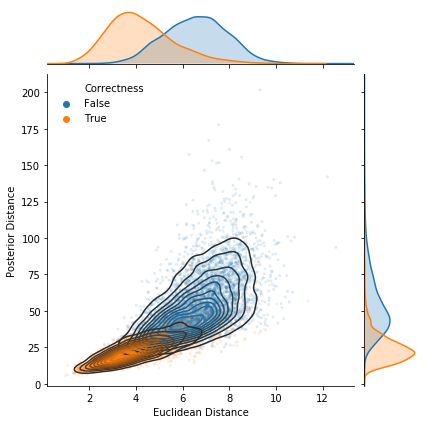

In [12]:
g = sns.JointGrid(x="Euclidean Distance", y="Posterior Distance", data=df)
for _correctness, _df in df.groupby("Correctness"):
    sns.kdeplot(_df["Euclidean Distance"], ax=g.ax_marg_x, legend=False, shade=True)
    sns.kdeplot(_df["Posterior Distance"], ax=g.ax_marg_y, vertical=True, legend=False, shade=True)
    sns.kdeplot(_df["Euclidean Distance"], _df["Posterior Distance"], n_levels=10, ax=g.ax_joint)
ax = sns.scatterplot(
    x="Euclidean Distance", y="Posterior Distance", hue="Correctness",
    data=df.sample(frac=1, random_state=0), s=5, edgecolor=None, alpha=0.1, ax=g.ax_joint
)
_ = g.ax_joint.legend(frameon=False)
ax.get_figure().savefig("./ed_pd.pdf", bbox_inches="tight")

In [13]:
def cb_roc(model):
    ref_clean = model.inference(ref, progress_bar=False).astype(np.float32)
    ref_noisy = model.inference(ref, noisy=50, progress_bar=False).astype(np.float32)
    query_clean = model.inference(query, progress_bar=False).astype(np.float32)
    query_noisy = model.inference(query, noisy=50, progress_bar=False).astype(np.float32)
    
    # Euclidean distance
    eud = np.sqrt(np.square(ref_clean[ref_idx] - query_clean[query_idx]).sum(axis=1))
    fpr, tpr, thresh = sklearn.metrics.roc_curve(correctness, -eud)
    eud_auc = sklearn.metrics.roc_auc_score(correctness, -eud)
    eud_fpr, eud_tpr = exputils.subsample_roc(fpr, tpr)
    
    # Posterior NPD (Normalized Projection Distance)
    pnpd = exputils.normalized_projection_distance(
        ref_clean[ref_idx], query_clean[query_idx],
        ref_noisy[ref_idx], query_noisy[query_idx]
    )
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(correctness, -pnpd)
    pnpd_auc = sklearn.metrics.roc_auc_score(correctness, -pnpd)
    pnpd_fpr, pnpd_tpr = exputils.subsample_roc(fpr, tpr)

    return eud_fpr, eud_tpr, eud_auc, \
        pnpd_fpr, pnpd_tpr, pnpd_auc

In [14]:
fpr, tpr, roc_distance, roc_seed = [], [], [], []
auc, auc_distance, auc_seed = [], [], []

for idx in tqdm.tqdm_notebook(range(N_MODELS)):
    eud_fpr, eud_tpr, eud_auc, pnpd_fpr, pnpd_tpr, pnpd_auc = cb_roc(cb_models[idx])

    fpr.append(eud_fpr)
    tpr.append(eud_tpr)
    auc.append(eud_auc)
    roc_distance.append(np.array(["Euclidean"] * len(eud_fpr)))
    roc_seed.append(np.ones(len(eud_fpr)) * idx)
    auc_distance.append("Euclidean")
    auc_seed.append(idx)

    fpr.append(pnpd_fpr)
    tpr.append(pnpd_tpr)
    auc.append(pnpd_auc)
    roc_distance.append(np.array(["Posterior NPD"] * len(pnpd_fpr)))
    roc_seed.append(np.ones(len(pnpd_fpr)) * idx)
    auc_distance.append("Posterior NPD")
    auc_seed.append(idx)

In [15]:
cb_roc_df = pd.DataFrame(dict(
    FPR=np.concatenate(fpr),
    TPR=np.concatenate(tpr),
    distance=np.concatenate(roc_distance),
    seed=np.concatenate(roc_seed),
    model="Cell BLAST"
))
cb_auc_df = pd.DataFrame(dict(
    AUC=auc, distance=auc_distance, seed=auc_seed,
    model="Cell BLAST"
))

---

# Plotting

In [16]:
cb_roc_df["Method"] = cb_roc_df["model"] + " with " + cb_roc_df["distance"]
scvi_roc_df["Method"] = scvi_roc_df["model"] + " + " + scvi_roc_df["distance"]
df = pd.concat([cb_roc_df, scvi_roc_df])
df.to_csv(os.path.join(PATH, "roc.csv"))

/home/caozj/Software/anaconda2/envs/tf1.8/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


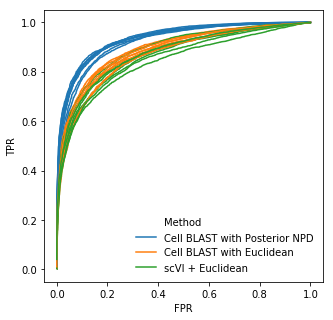

In [17]:
_, ax = plt.subplots(figsize=(5, 5))
sub_df = df.query("Method != 'scVI + Posterior NPD' & Method != 'scVI + Posterior JSD'")
for i in range(16):
    plot = sns.lineplot(
        data=sub_df.query("seed == %d" % i), x="FPR", y="TPR", hue="Method",
        legend="brief" if i == 0 else False, ax=ax,
        hue_order=[
            "Cell BLAST with Posterior NPD",
            "Cell BLAST with Euclidean",
            "scVI + Euclidean"
        ]
    )
_ = plt.legend(frameon=False)
plot.get_figure().savefig(os.path.join(PATH, "roc.pdf"), bbox_inches="tight")

In [18]:
cb_auc_df["Method"] = cb_auc_df["model"] + " with " + cb_auc_df["distance"]
scvi_auc_df["Method"] = scvi_auc_df["model"] + " + " + scvi_auc_df["distance"]
df = pd.concat([cb_auc_df, scvi_auc_df])
df.to_csv(os.path.join(PATH, "auc.csv"))

In [19]:
df = pd.read_csv(os.path.join(PATH, "auc.csv"))

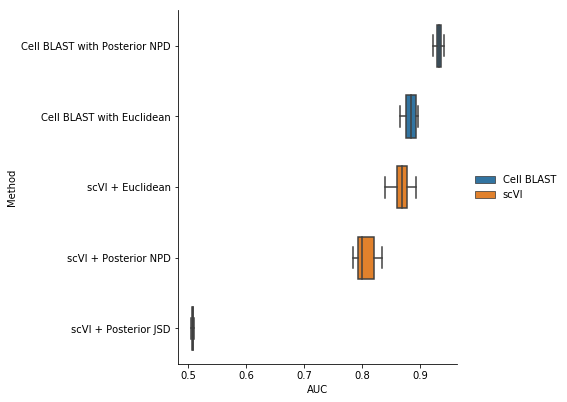

In [20]:
_, ax = plt.subplots(figsize=(5, 6.5))
plot = sns.boxplot(
    data=df, x="AUC", y="Method", hue="model",
    order=[
        "Cell BLAST with Posterior NPD",
        "Cell BLAST with Euclidean",
        "scVI + Euclidean",
        "scVI + Posterior NPD",
        "scVI + Posterior JSD"
    ], dodge=False, width=0.6, ax=ax
)
plot.spines["right"].set_visible(False)
plot.spines["top"].set_visible(False)
_ = plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), borderaxespad=0.0, frameon=False)
plot.get_figure().savefig(os.path.join(PATH, "auc.pdf"), bbox_inches="tight")